In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

nbn = "03_" # Notebook Number; Prefix for artifacts path

In [25]:
datasets = ["DTD","EuroSAT","GTSRB","MNIST","SVHN","Caltech256","SUN397","iWildCam"]
# datasets = ["DTD","EuroSAT","Caltech256"]
nrow, ncol=3, 3

In [26]:
def calc_tpr(targ, pred):
    tp = np.sum((targ == 1) & (pred == 1))
    fn = np.sum((targ == 1) & (pred == 0))
    return tp / (tp + fn)
def calc_fpr(targ, pred):
    fp = np.sum((targ == 0) & (pred == 1))
    tn = np.sum((targ == 0) & (pred == 0))
    return fp / (fp + tn)
def predict_correctness(ent_ls,threshold):
    return np.where(ent_ls>threshold,0,1)

In [27]:
def auroc(pred_vec, target_vec, unc_vec, label, ax):
    cor_pred = np.where(pred_vec == target_vec, 1, 0)
    max_unc = unc_vec.max()
    min_unc = unc_vec.min()
    tpr = np.array([]) 
    fpr = np.array([])
    step = (max_unc - min_unc) / 200
    # print(f"{max_unc = }, {min_unc = }, {step = }")
    for ent_step in np.arange(min_unc, max_unc+step, step):
        temp = predict_correctness(unc_vec, ent_step)
        tpr = np.append(tpr, calc_tpr(cor_pred, temp))
        fpr = np.append(fpr, calc_fpr(cor_pred, temp))
    area = np.trapz(tpr, fpr)
    sns.lineplot(x=fpr, y=tpr, label=f"{label} (AUC: {area:.2f})", ax=ax)
    return area

/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tim

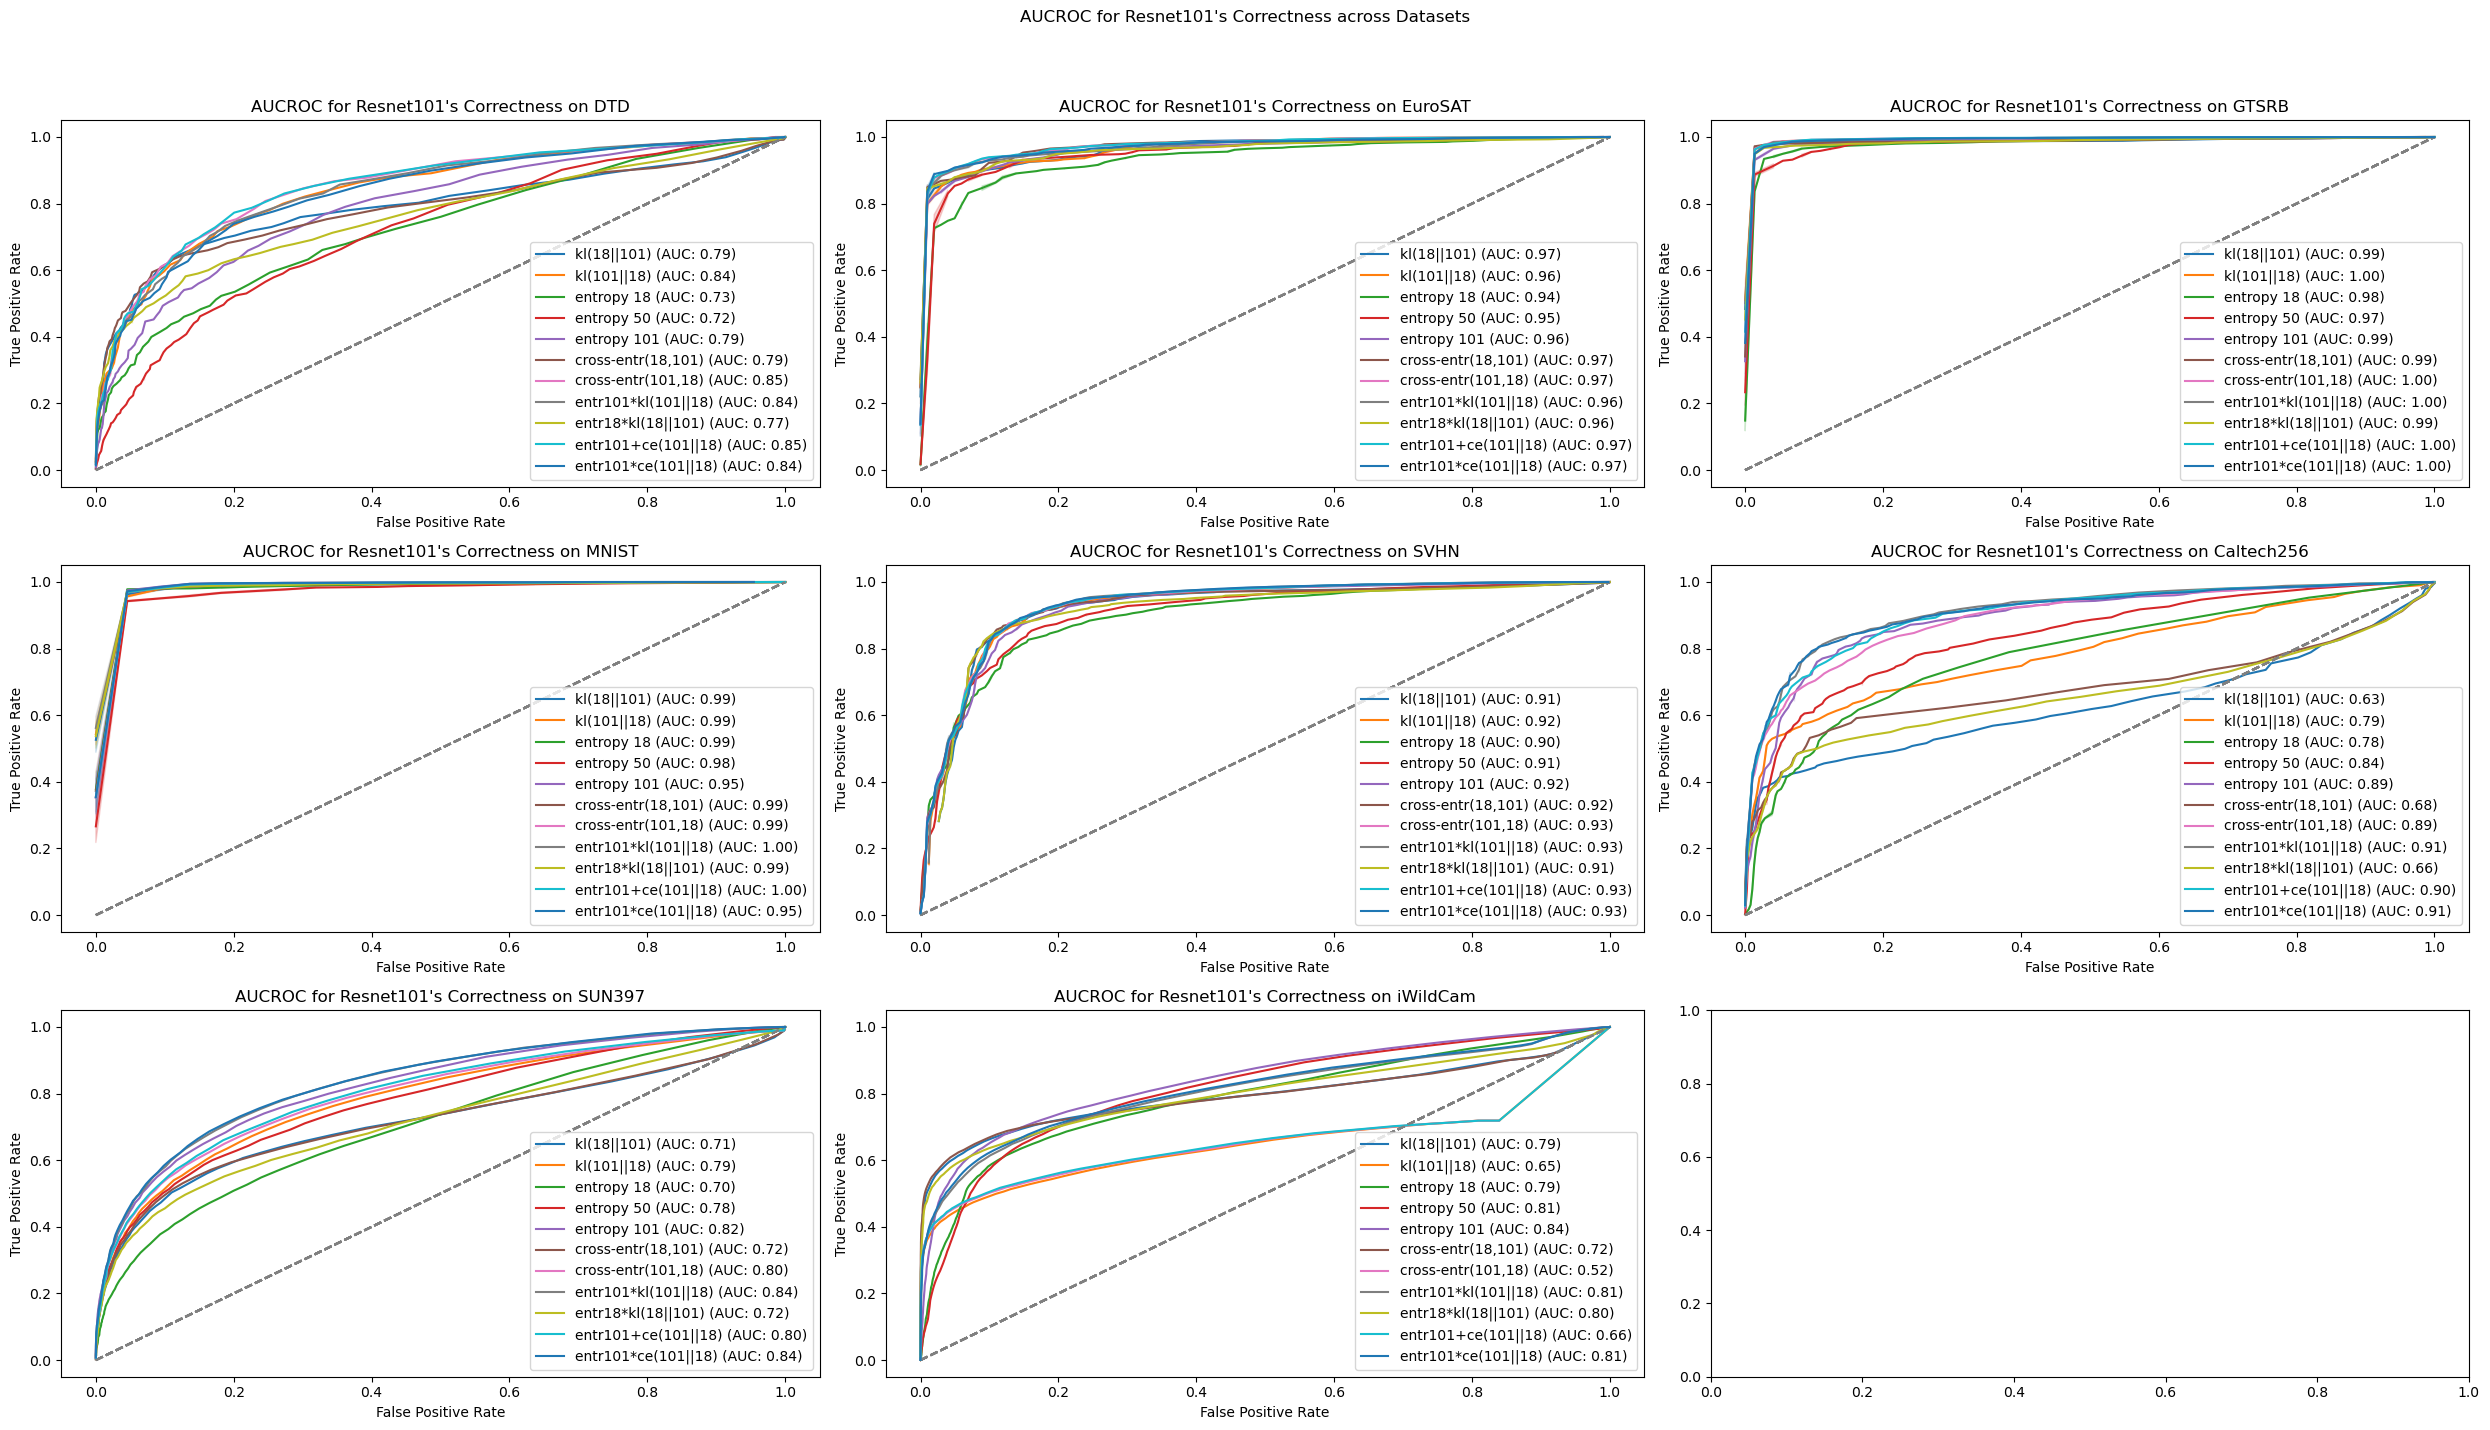

In [28]:
fig, axes = plt.subplots(nrow, ncol, figsize=(25, 15))

for i, ds in enumerate(datasets):
    pred = pd.read_csv(f"prediction_{ds}.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"uncertainty_{ds}.csv", index_col="Unnamed: 0").clip(-100,100)
    
    metrics = [
        (np.log(unc_pred["ent_18"]), "entropy 18"),
        (np.log(unc_pred["ent_50"]), "entropy 50"),
        (np.log(unc_pred["kl_18_101"]), "kl(18||101)"),
        (np.log(unc_pred["kl_101_18"]), "kl(101||18)"),
        (np.log(unc_pred["ent_101"]), "entropy 101"),
        (np.log(unc_pred["ce_18_101"]), "cross-entr(18,101)"),
        (np.log(unc_pred["ce_101_18"]), "cross-entr(101,18)"),
        (np.log(unc_pred["ent_101"] * unc_pred["kl_101_18"]), "entr101*kl(101||18)"),
        (np.log(unc_pred["ent_18"] * unc_pred["kl_18_101"]), "entr18*kl(18||101)"),
        (np.log(unc_pred["ent_101"] + unc_pred["ce_101_18"]), "entr101+ce(101||18)"),
        (np.log(unc_pred["ent_101"] * unc_pred["ce_101_18"]), "entr101*ce(101||18)")
    ]
    
    ax = axes[i // ncol, i % ncol]
    for metric, label in metrics:
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
        auroc(pred["pred101"], pred["target"], metric, label, ax)
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"AUCROC for Resnet101's Correctness on {ds}")
        ax.legend(loc="lower right")

plt.suptitle("AUCROC for Resnet101's Correctness across Datasets")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
plt.savefig(f"artifacts/{nbn}aucroc.png")
plt.show()

In [29]:
fig, axes = plt.subplots(nrow, ncol, figsize=(25, 15))

for i, ds in enumerate(datasets):
    evaluate_on = "pred101"
    pred = pd.read_csv(f"prediction_{ds}.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"uncertainty_{ds}.csv", index_col="Unnamed: 0").clip(-100,100)
    
    metrics = [
        (np.log(unc_pred["ent_18"]), "entropy 18"),
        (np.log(unc_pred["ent_50"]), "entropy 50"),
        (np.log(unc_pred["ent_101"]), "entropy 101"),
        (np.log(unc_pred["kl_18_50"]), "kl(18||50)"),
        (np.log(unc_pred["kl_50_18"]), "kl(50||18)"),
        (np.log(unc_pred["ce_18_50"]), "cross-entr(18,50)"),
        (np.log(unc_pred["ce_50_18"]), "cross-entr(50,18)"),
        (np.log(unc_pred["ent_50"] * unc_pred["kl_50_18"]), "entr50*kl(50||18)"),
        (np.log(unc_pred["ent_18"] * unc_pred["kl_18_50"]).clip(-100,100), "entr18*kl(18||50)"),
        (np.log(unc_pred["ent_50"] + unc_pred["ce_50_18"]), "entr50+ce(50||18)"),
        (np.log(unc_pred["ent_50"] * unc_pred["ce_50_18"]), "entr50*ce(50||18)")
    ]
    
    ax = axes[i // ncol, i % ncol]
    for metric, label in metrics:
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
        auroc(pred[evaluate_on], pred["target"], metric, label, ax)
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"AUCROC for Resnet101's Correctness on {ds}")
        ax.legend(loc="lower right")

plt.suptitle(f"AUCROC for {evaluate_on}'s Correctness across Datasets")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
plt.savefig(f"artifacts/{nbn}aucroc_50.png")
plt.show()

/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
